# Object Identification #
This workbook is for me to practice different methods that I could potentially use in a project for my internship. I don't have a lot of experience working with images so it was helpful to practice with the package scikit-image. I used a thermal image as I would be doing something similar in my project work. 

I am trying to pick out an object from an image and exclude the background. This could be turned into an automatic script potentially.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage as ndi
import skimage
from skimage import feature
from skimage.color import rgb2gray
#had to import this command seperately for some reason
from skimage.io import imread

In [2]:
# Read in image
img = imread("pig_thermal.jpg")
#convert to greyscale
im = rgb2gray(img)

## Original Image ##

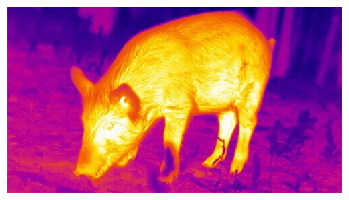

In [3]:
plt.imshow(img)
plt.axis('off')
plt.show()

### Thresholding ###
Going to using various thresholding methods. First I am going to make a histogram to see the values in the picture.

In [4]:
# first creating a function to make a grayscale histogram for later
def create_gr_hist(image):
    # create the histogram
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 1))

    # plot histogram
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("Value")
    plt.ylabel("Pixels")
    # plot is offset so changing this
    plt.xlim([0.0, 1.0])  

    plt.plot(bin_edges[0:-1], histogram)  # <- or here
    plt.show()

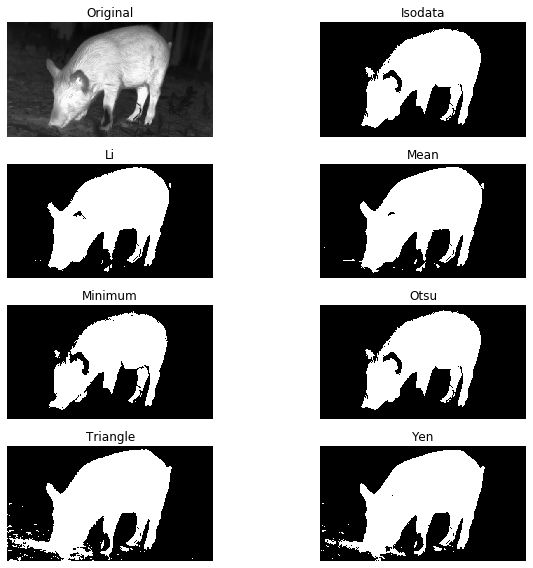

In [5]:
# Using a nice function to try all of the thresholds to get a quick view
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(im, figsize=(10, 8), verbose=False)
plt.show()

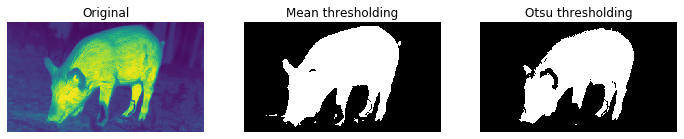

In [6]:
# Trying the two that I think worked the best
from skimage.filters import threshold_otsu, threshold_mean

# mean threshold
thresh = threshold_mean(im)
binary_mean = im > thresh

# otsu
thresh = threshold_otsu(im)
binary_otsu = im > thresh

fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(im)
ax[0].set_title('Original')

ax[1].imshow(binary_mean, cmap=plt.cm.gray)
ax[1].set_title('Mean thresholding')

ax[2].imshow(binary_otsu, cmap=plt.cm.gray)
ax[2].set_title('Otsu thresholding')

# Remove axis
for a in ax:
    a.axis('off')

plt.show()

### Canny Edge Detection ###
This requires blurring the image and attempting to find the edges, then fill it to get the object.

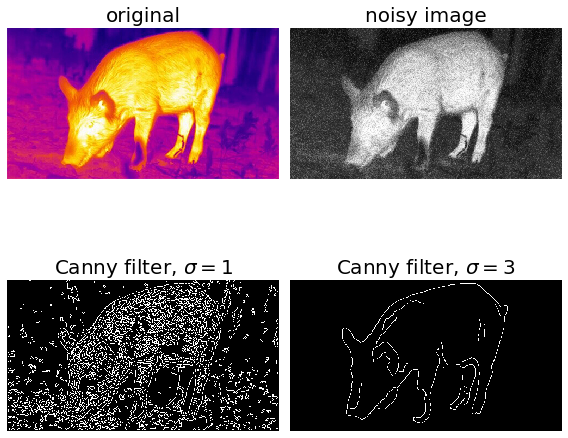

In [7]:
# apply gaussian blur to image
img2 = skimage.util.random_noise(img, mode='gaussian', seed=None, clip=True, var=0.01)

#convert to grayscale
im = rgb2gray(img2)

# Compute the Canny filter for two values of sigma (default is 1)
edges1 = feature.canny(im)

sig = 3
edges2 = feature.canny(im, sigma=sig)

# display results
fig, axes = plt.subplots(2,2, figsize=(8,8))
ax = axes.ravel()

ax[0].imshow(img)
ax[0].set_title('original', fontsize=20)

ax[1].imshow(im, cmap=plt.cm.gray)
ax[1].set_title('noisy image', fontsize=20)

ax[2].imshow(edges1, cmap=plt.cm.gray)
ax[2].set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax[3].imshow(edges2, cmap=plt.cm.gray)
ax[3].set_title(r'Canny filter, $\sigma=${}'.format(sig), fontsize=20)

# Remove axis
for a in ax:
    a.axis('off')

fig.tight_layout()

plt.show()

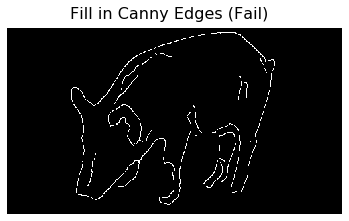

In [8]:
# Attempting to fill in the picture, it fails since the lines aren't connected
fill_pic = ndi.binary_fill_holes(edges2)
plt.imshow(fill_pic, cmap=plt.cm.gray)
plt.suptitle('Fill in Canny Edges (Fail)', fontsize=16, y=0.90)
plt.axis('off')
plt.show()

### Watershed Segmentation ###
Removing Background and then marking picture for flooding.

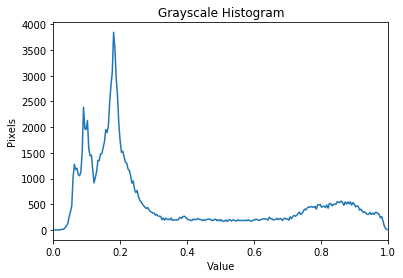

In [9]:
im = rgb2gray(img)
create_gr_hist(im)

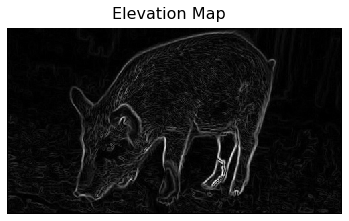

In [10]:
#Setting markers based off the histogram
markers = np.zeros_like(im)
markers[im < 0.10] = 1
markers[im > 0.4] = 2

from skimage.filters import sobel
elevation_map = sobel(im)
plt.imshow(elevation_map, cmap=plt.cm.gray)
plt.suptitle('Elevation Map', fontsize=16, y=0.90)
plt.axis('off')
plt.show()

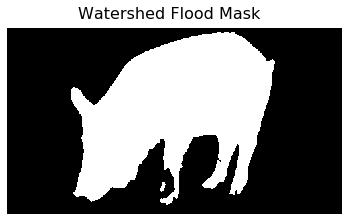

In [11]:
from skimage.segmentation import watershed
segmentation = watershed(elevation_map, markers)
plt.imshow(segmentation, cmap=plt.cm.gray)
plt.suptitle('Watershed Flood Mask', fontsize=16, y=0.90)
plt.axis('off')
plt.show()

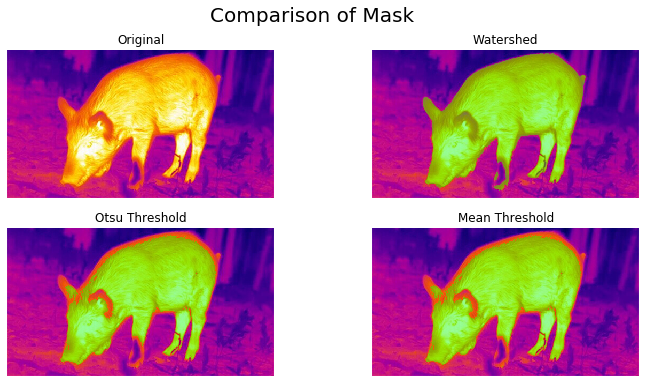

In [12]:
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(2, 2, figsize=(12, 6))
plt.suptitle('Comparison of Mask', fontsize=20)
ax1.imshow(img)
ax1.set_title('Original')
ax1.axis('off')

ax2.imshow(img)
# create mask
img_mask = img.copy()
mask = segmentation >1
img_mask[mask] = [0,255,0]
ax2.imshow(img_mask, cmap=plt.cm.plasma, alpha = 0.4)
ax2.set_title('Watershed')
ax2.axis('off')

ax3.imshow(img)
img_mask = img.copy()
img_mask[binary_otsu] = [0,255,0]
#plot
ax3.imshow(img_mask, cmap=plt.cm.plasma, alpha = 0.4)
ax3.set_title('Otsu Threshold')
ax3.axis('off')

ax4.imshow(img)
img_mask = img.copy()
img_mask[binary_otsu] = [0,255,0]
#plot
ax4.imshow(img_mask, cmap=plt.cm.plasma, alpha = 0.4)
ax4.set_title('Mean Threshold')
ax4.axis('off')

plt.show()

### Conclusions ###
Overall this was a fun problem to solve. The thresholding worked pretty well and was able to identify a solid mask. However, it left out the ears and an outer line of the thermal image. The Canny Edge detection was not able to correctly find all the edges so I could make a filled image. I believe the Watershed method worked the best out of all of them and was able to identify most of the pig. Only a couple of pieces on the leg that resembled background were excluded. 